# LSTM  for turbofan dataset
The idea is to implement a LSTM model and compare it with a hybrid approach combining both LSTM and CNN since these have performed quite well on the turbofan dataset (https://ieeexplore.ieee.org/abstract/document/9613682?casa_token=FOmYn4OJNFMAAAAA:jbDObYMd4m9AFhQu8QObrMVTunUDhfjkeNHBIlJ_9H1-A6uEap-pJXUaYXTxsV4R7uvh7SOSrA).
For the LSTM, we attempted to tune the parameters and for the hybrid approach we adopted the architecture of a selected paper (https://ieeexplore.ieee.org/document/8683763). However, the results were not satisfactory and the RMSE remained quite high.

In [ ]:
!pip install ray
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import GroupKFold
import ray
from ray import train, tune
from ray.train import Checkpoint
from ray.tune.schedulers import ASHAScheduler
import os
import json


# Load Data

In [7]:
FD001_train = pd.read_csv('data/train_FD001.txt', sep='\s+', header=None)
FD001_test = pd.read_csv('data/test_FD001.txt', sep='\s+', header=None)
FD002_train = pd.read_csv('data/train_FD002.txt', sep='\s+', header=None)
FD002_test = pd.read_csv('data/test_FD002.txt', sep='\s+', header=None)
FD003_train = pd.read_csv('data/train_FD003.txt', sep='\s+', header=None)
FD003_test = pd.read_csv('data/test_FD003.txt', sep='\s+', header=None)
FD004_train = pd.read_csv('data/train_FD004.txt', sep='\s+', header=None)
FD004_test = pd.read_csv('data/test_FD004.txt', sep='\s+', header=None)

In [8]:
FD001_test_targets = pd.read_csv('data/RUL_FD001.txt',sep='\s+', header=None, names=["RUL"])
FD002_test_targets = pd.read_csv('data/RUL_FD002.txt',sep='\s+', header=None, names=["RUL"])
FD003_test_targets = pd.read_csv('data/RUL_FD003.txt',sep='\s+', header=None, names=["RUL"])
FD004_test_targets = pd.read_csv('data/RUL_FD004.txt',sep='\s+', header=None, names=["RUL"])

In [9]:
# Define column names
index_columns_names =  ["unit_number","cycle"]
operational_settings_columns_names = ["operational_setting_"+str(i) for i in range(1,4)]
sensor_measure_columns_names =["sensor_"+str(i) for i in range(1,22)]
input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

In [10]:
FD001_train.columns = input_file_column_names
FD001_test.columns = input_file_column_names
FD002_train.columns = input_file_column_names
FD002_test.columns = input_file_column_names
FD003_train.columns = input_file_column_names
FD003_test.columns = input_file_column_names
FD004_train.columns = input_file_column_names
FD004_test.columns = input_file_column_names

In [11]:
datasets = {}

# FD001 data
datasets['FD001'] = {
    'train': FD001_train,
    'test': FD001_test,
    'test_targets': FD001_test_targets
}

# FD002 data
datasets['FD002'] = {
    'train': FD002_train,
    'test': FD002_test,
    'test_targets': FD002_test_targets
}

# FD003 data
datasets['FD003'] = {
    'train': FD003_train,
    'test': FD003_test,
    'test_targets': FD003_test_targets
}

# FD004 data
datasets['FD004'] = {
    'train': FD004_train,
    'test': FD004_test,
    'test_targets': FD004_test_targets
}

In [12]:
for engine_id, engine_data in datasets.items():
    print(f"{engine_id} Train dataset size: {len(engine_data['train'])}")
    print(f"{engine_id} Test_target dataset size: {len(engine_data['test_targets'])}")
    engine_df = engine_data["test"]
    grouped_by_unit = engine_df.groupby(by="unit_number")
    max_cycle = grouped_by_unit["cycle"].max()
    min_max_cycle = max_cycle.min()
    engine_data["max_window_size"] = min_max_cycle
    print(f"{engine_id} test data: Minimum of maximum cycle values: {min_max_cycle}")

FD001 Train dataset size: 20631
FD001 Test_target dataset size: 100
FD001 test data: Minimum of maximum cycle values: 31
FD002 Train dataset size: 53759
FD002 Test_target dataset size: 259
FD002 test data: Minimum of maximum cycle values: 21
FD003 Train dataset size: 24720
FD003 Test_target dataset size: 100
FD003 test data: Minimum of maximum cycle values: 38
FD004 Train dataset size: 61249
FD004 Test_target dataset size: 248
FD004 test data: Minimum of maximum cycle values: 19


# Preprocessing

## Helper Functions

In [13]:
def calculate_rul(df, initial_rul=0):
    """
    Calculates target RUL for a dataframe. If initial_rul is != 0 piece-wise linear degradation is calculated 
    (Initially, RUL is set to constant value until degradation starts). Otherwise, RUL is linear degradation 
    and starts with max_cycle number for a motor unit.
    
    Parameters:
    - df: DataFrame containing the data
    - initial_rul: Initial constant RUL value before degradation starts
    
    Returns:
    - numpy array containing the RUL values for the entire dataframe
    """
    grouped = df.groupby("unit_number")
    ruls = []

    for _, unit in grouped:
        max_cycle = unit.shape[0]
        targets = np.arange(max_cycle-1, -1, -1)  # create array from max_cycle-1 to 0
        if initial_rul > 0:
            targets = np.clip(targets, None, initial_rul)
        ruls.append(targets)
    
    return np.concatenate(ruls)

In [14]:
def scale(df, scaler, train=True):
    df_scaled = df.copy()
    columns_to_scale = operational_settings_columns_names + sensor_measure_columns_names
    if train: 
        df_scaled[columns_to_scale] = scaler.fit_transform(df_scaled[columns_to_scale])
    else:
        df_scaled[columns_to_scale] = scaler.transform(df_scaled[columns_to_scale])
    return df_scaled, scaler

In [15]:
def generate_sequence(df, window_size=30, stride=1):
    grouped = df.groupby("unit_number")
    X_processed = []
    y_processed = []
    for _, unit in grouped:
        #unit_data = unit.sort_values(by="cycle", ascending=True)
        target = unit["rul"]
        windows = extract_windows(unit.drop(["cycle", "rul"],axis=1), window_size, stride)
        X_processed.append(windows)
        targets_for_windows = target[-windows.shape[0]::] #the target for a window is target rul of value at the end of window. So the first num_windows values of target care cut off
        y_processed.append(targets_for_windows)
    X_processed = np.concatenate(X_processed) # shape (number of total extracted windows,window size,  features)
    y_processed = np.concatenate(y_processed) # shape (number of total extracted windows)
    return X_processed, y_processed
    
def extract_windows(data, window_size, stride):
    if data.shape[0] < window_size:
            raise AssertionError("Window length is larger than sequence length ")
    windows = sliding_window_view(data, window_shape=(window_size, data.shape[1])).squeeze() #squeeze to remove dimension with 1
    if stride != 1:
        windows = windows[::stride]
    return windows  


# Take last window for final prediction
def generate_test_sequence(df,  window_size=30, stride=1):
    grouped = df.groupby("unit_number")
    X_processed = []
    for _, unit in grouped:
        #unit_data = unit.sort_values(by="cycle", ascending=True)
        #windows = extract_windows(unit.drop(["cycle"],axis=1), window_size, stride)
        #windows = windows[-n_windows:]  # take only last n windows
        window = unit.drop(["cycle"], axis=1)[-window_size:]
        X_processed.append(window)
       
    X_processed = np.stack(X_processed) # shape (number_units, window_size, features)

    return X_processed

## Dataset classes for Preprocessing

For the prediction only the last window of each motor is used.

In [16]:
class CMAPPSDataset(Dataset):
    def __init__(self, data, scaler, columns_to_drop, window_size, stride, initial_rul = 0, train=True):
        self.data = data
        if scaler is None:
            self.scaler = StandardScaler()
        elif isinstance(scaler, type):
            self.scaler = scaler()  # scaler is a class, so we instantiate it
        else:
            self.scaler = scaler  # scaler is already an instance
        
        # if train is true scaler does fit_transform(). Else only transform()

        self.X, self.scaler  = scale(self.data, scaler=self.scaler, train=train)
        self.X = self.X.drop(columns_to_drop,axis=1)
        self.X["rul"] = calculate_rul(self.data, initial_rul = initial_rul)
        self.X_seq, self.y_seq = generate_sequence(self.X, window_size=window_size, stride=stride)



    def __len__(self):
        return len(self.X_seq)


    def __getitem__(self, idx):
         sample =  torch.tensor(self.X_seq[idx], dtype=torch.float)
         target =  torch.tensor(self.y_seq[idx], dtype=torch.float)
         return sample, target

    def get_scaler(self):
        return self.scaler


class CMAPPSTestDataset(Dataset):
    def __init__(self, data, targets, scaler, columns_to_drop, window_size, stride, n_windows=1):
        self.data = data
        self.targets = targets
        self.scaler = scaler #is already instantiated scaler
        self.y = targets.squeeze()

        # if train is true scaler is fit and transform. Else only transform
        self.X, self.scaler  = scale(self.data, scaler=self.scaler, train=train)
        self.X = self.X.drop(columns_to_drop,axis=1)
        self.X_seq = generate_test_sequence(self.X, window_size=window_size, stride=stride)
        

    def __len__(self):
        return len(self.X_seq)


    def __getitem__(self, idx):
         sample =  torch.tensor(self.X_seq[idx], dtype=torch.float)
         target =  torch.tensor(self.y[idx], dtype=torch.float)
         return sample, target

## Preprocessing tests

In [17]:
# Test
unit_1_df = FD001_train[FD001_train["unit_number"]==1].copy()
print("rul piecewise-linear: " , calculate_rul(unit_1_df, initial_rul=125))
print("rul linear: ",  calculate_rul(unit_1_df))

rul piecewise-linear:  [125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125
 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125
 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125
 125 125 125 125 125 125 125 125 125 125 125 125 125 124 123 122 121 120
 119 118 117 116 115 114 113 112 111 110 109 108 107 106 105 104 103 102
 101 100  99  98  97  96  95  94  93  92  91  90  89  88  87  86  85  84
  83  82  81  80  79  78  77  76  75  74  73  72  71  70  69  68  67  66
  65  64  63  62  61  60  59  58  57  56  55  54  53  52  51  50  49  48
  47  46  45  44  43  42  41  40  39  38  37  36  35  34  33  32  31  30
  29  28  27  26  25  24  23  22  21  20  19  18  17  16  15  14  13  12
  11  10   9   8   7   6   5   4   3   2   1   0]
rul linear:  [191 190 189 188 187 186 185 184 183 182 181 180 179 178 177 176 175 174
 173 172 171 170 169 168 167 166 165 164 163 162 161 160 159 158 157 156
 155 154 153 152 151 150 149 148 147 1

In [18]:
a = np.arange(1,21).reshape(10,2) #first dimension is time step
print(a)
print(a.shape)
b = np.arange(1,11)
X = extract_windows(a, window_size=2, stride=1)
print("\n Extracted windows  with window size 2\n", X)

[[ 1  2]
 [ 3  4]
 [ 5  6]
 [ 7  8]
 [ 9 10]
 [11 12]
 [13 14]
 [15 16]
 [17 18]
 [19 20]]
(10, 2)

 Extracted windows  with window size 2
 [[[ 1  2]
  [ 3  4]]

 [[ 3  4]
  [ 5  6]]

 [[ 5  6]
  [ 7  8]]

 [[ 7  8]
  [ 9 10]]

 [[ 9 10]
  [11 12]]

 [[11 12]
  [13 14]]

 [[13 14]
  [15 16]]

 [[15 16]
  [17 18]]

 [[17 18]
  [19 20]]]


In [19]:
data = FD001_train.copy()

X= data
X["rul"] = calculate_rul(data)
print(X.shape)
print(X["rul"].shape)

X, _ = scale(X, StandardScaler())
columns_to_drop_test = ['operational_setting_1', 'operational_setting_2', 'operational_setting_3', 
                   'sensor_1', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9',
                   'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21']
X = X.drop( columns_to_drop_test, axis=1)
print(X.shape)
print(X.head())

(20631, 27)
(20631,)
(20631, 5)
   unit_number  cycle  sensor_2  sensor_17  rul
0            1      1 -1.721725  -0.781710  191
1            1      2 -1.061780  -0.781710  190
2            1      3 -0.661813  -2.073094  189
3            1      4 -0.661813  -0.781710  188
4            1      5 -0.621816  -0.136018  187


In [20]:
X_seq, y_seq = generate_sequence(X, window_size=30, stride=1)
print(X_seq.shape)
print(y_seq.shape)

(17731, 30, 3)
(17731,)


In [21]:
data = FD001_test.copy()

X_seq = generate_test_sequence(data, window_size=30, stride=1)
print(data.shape)
print("Target shape: ", FD001_test_targets.shape)
print("Test seq shape", X_seq.shape)


(13096, 26)
Target shape:  (100, 1)
Test seq shape (100, 30, 25)


In [22]:
print(FD001_train.shape)
dataset = CMAPPSDataset(FD001_train.copy(), StandardScaler, [], window_size=30, stride=1, initial_rul = 130, train=True)
scaler = dataset.get_scaler()
print(dataset.X_seq.shape)
print(dataset.y_seq.shape)
#print(dataset.X_seq[0])
print(dataset.y_seq[0])
test_dataset = CMAPPSTestDataset(FD001_test, FD001_test_targets, scaler, [], window_size=30, stride=1)
print(test_dataset.X_seq.shape)
print(test_dataset.y.shape)

(20631, 26)
(17731, 30, 25)
(17731,)
130
(100, 30, 25)
(100,)


# Models

In [23]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, lstm_hidden_sizes=[64], fc_hidden_sizes=[64], output_size=1, activation=nn.ReLU, dropout=0.0, lstm_activation=nn.Tanh):
        super(LSTMModel, self).__init__()

        self.lstm_hidden_sizes = lstm_hidden_sizes
        self.fc_hidden_sizes = fc_hidden_sizes
        self.lstm_layers = []
        self.fc_layers = []
        self.activation = activation()
        self.dropout = dropout
        self.lstm_activation = lstm_activation()
        self.dropout = nn.Dropout(dropout)
        
        # LSTM layers
        num_lstm_layers = len(lstm_hidden_sizes)
        lstm_input_size = input_size
        for i in range(num_lstm_layers):
            hidden_size = lstm_hidden_sizes[i] if i < len(lstm_hidden_sizes) else lstm_hidden_sizes[-1]
            self.lstm_layers.append(nn.LSTM(lstm_input_size, hidden_size, batch_first=True))
            lstm_input_size = hidden_size
        
        self.lstm = nn.ModuleList(self.lstm_layers)
        
        # FC layers
        num_fc_layers = len(fc_hidden_sizes)
        fc_input_size = lstm_hidden_sizes[-1] if lstm_hidden_sizes else input_size
        for i in range(num_fc_layers):
            hidden_size = fc_hidden_sizes[i] if i < len(fc_hidden_sizes) else fc_hidden_sizes[-1]
            self.fc_layers.append(nn.Linear(fc_input_size, hidden_size))
            fc_input_size = hidden_size
        
        self.fc = nn.ModuleList(self.fc_layers)
        self.output_layer = nn.Linear(fc_input_size, output_size)
    
    def forward(self, x):
        # LSTM layers
        for i, lstm_layer in enumerate(self.lstm):
            x, _ = lstm_layer(x)
            if self.lstm_activation:
                x = self.lstm_activation(x)
            #x = self.dropout(x)
        
        # FC layers
        for i, fc_layer in enumerate(self.fc):
            x = fc_layer(x)
            x = self.activation(x) if i < len(self.fc_layers) - 1 else x
            x = self.dropout(x)
        
        out = self.output_layer(x[:, -1, :])  # Taking the last output from the sequence
        return out.squeeze()



## Hybrid Deep Neural Network
https://ieeexplore.ieee.org/document/8683763
<img src="image/HDNN.png" alt="Alt text" title="Optional title">

In [24]:
# input is (batch, window_size, features)

class HybridDeepNeuralNetwork(nn.Module):
    def __init__(self, input_size, window_size, lstm_hidden_sizes=[32, 32, 64],  output_size=1, activation=nn.ReLU, dropout=0.0,  kernel_sizes = [(10,1), (10,1), (3,1)], out_channels = [10, 10, 1], kernel_max_pool_size=(2,1), fc_hidden_sizes = [100, 100]):
        super(HybridDeepNeuralNetwork, self).__init__()
        self.feature_dim = input_size
        num_lstm_layers = len(lstm_hidden_sizes)
        lstm_input_size =  self.feature_dim
        self.lstm_layers = []
        for i in range(num_lstm_layers):
            hidden_size = lstm_hidden_sizes[i] if i < len(lstm_hidden_sizes) else lstm_hidden_sizes[-1]
            self.lstm_layers.append(nn.LSTM(lstm_input_size, hidden_size, batch_first=True, dropout=dropout))
            lstm_input_size = hidden_size
        
        self.lstm = nn.ModuleList(self.lstm_layers)


        self.conv_layers = []
        num_conv_layers = len(kernel_sizes)
        in_channels = [1] + out_channels[:-1]
        for i in range(num_conv_layers):
            self.conv_layers.append(nn.Conv2d(in_channels=in_channels[i], out_channels=out_channels[i], kernel_size=kernel_sizes[i], padding='same'))
            if i != (num_conv_layers-1):
                self.conv_layers.append(nn.MaxPool2d(kernel_size=kernel_max_pool_size))
        self.conv = nn.ModuleList(self.conv_layers)

         # FC layers
        num_fc_layers = len(fc_hidden_sizes)
        fc_input_size = lstm_hidden_sizes[-1] + ( window_size // (2 ** (num_conv_layers - 1))  * self.feature_dim)
        self.fc_layers = []
        for i in range(num_fc_layers):
            hidden_size = fc_hidden_sizes[i] if i < len(fc_hidden_sizes) else fc_hidden_sizes[-1]
            self.fc_layers.append(nn.Linear(fc_input_size, hidden_size))
            self.fc_layers.append(nn.Tanh())
            fc_input_size = hidden_size
        
        self.fc = nn.ModuleList(self.fc_layers)
        self.output_layer = nn.Linear(fc_input_size, output_size)

    def forward(self, x):
         # LSTM forward pass
        # x has shape (batch, window_size, feature_dim)
        lstm_out = x
        for lstm_layer in self.lstm_layers:
            lstm_out, _ = lstm_layer(lstm_out)
        
        # Convolutional forward pass
        conv_out = x.unsqueeze(1)  # Add a channel dimension
        #conv_out = x.permute(0,2,1) # conv2d input shape (batch, channel, h x w)
        for conv_layer in self.conv_layers:
            conv_out = conv_layer(conv_out)
           # print("conv out", conv_out.shape)
            
        conv_out_flat =  conv_out.reshape(conv_out.shape[0], -1)
        combined= torch.cat([lstm_out[:, -1, :], conv_out_flat], dim=1)
        # Fully connected layers forward pass
        fc_out = combined
        for fc_layer in self.fc_layers:
            fc_out = fc_layer(fc_out)
        out = self.output_layer(fc_out)
        return out



# Train and evaluation loop
Using 5-Fold Cross Validation, the training set is split by groups.

In [25]:
import time

def compute_s_score(rul_pred, rul_true):
    diff = rul_pred - rul_true
    return torch.mean(torch.where(diff < 0, torch.exp(-diff/13)-1, torch.exp(diff/10)-1))

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    #print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()
       
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        if outputs.dim() == 0:  # Handle the case where outputs is a scalar
            outputs = outputs.unsqueeze(0)
        loss = criterion(outputs, targets)
        running_loss +=loss.item()
        loss.backward()
        optimizer.step()
        
    total_train_loss = running_loss / len(train_loader)
    return total_train_loss


def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    score = 0.0
    #total_samples = 0
    all_outputs = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).squeeze()
            if outputs.dim() == 0:  # Handle the case where outputs is a scalar
                outputs = outputs.unsqueeze(0)
            all_outputs.append(outputs)
            loss = criterion(outputs, targets)
            running_loss +=loss.item()  * inputs.size(0)
            score += compute_s_score(outputs, targets).item()  * inputs.size(0)
            #score = compute_s_score(outputs, targets)
            #scores.append(score.item()) 

    total_loss = running_loss / len(val_loader.dataset)
    mean_score = score / len(val_loader.dataset)
    all_outputs = torch.cat(all_outputs, dim=0)
    return total_loss, mean_score, all_outputs # Divide by the total number of samples



def train_model(params: dict, data):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(42)
  
    # Cross Validation
    n_splits=5
    losses = []
    scores = []
    
    criterion = nn.MSELoss()

    
    for fold, (train_ids, val_ids) in enumerate(GroupKFold(n_splits=n_splits).split(data, y=None, groups= data["unit_number"].copy())):
        print(f" Start training Fold {fold + 1}/{n_splits}")

        # Load datasets and perform preproccesing
        #start_time = time.time()
        train_subset = CMAPPSDataset( data=data.iloc[train_ids], scaler=params["scaler_cls"], columns_to_drop=params["columns_to_drop"], window_size=params["window_size"], stride=params["stride"], initial_rul = params["initial_rul"], train=True)
        train_scaler = train_subset.get_scaler()
        
        val_subset = CMAPPSDataset( data=data.iloc[val_ids], scaler=train_scaler, columns_to_drop=params["columns_to_drop"], window_size=params["window_size"], stride=params["stride"],initial_rul =  params["initial_rul"], train=False)
        #end_time = time.time()
        #elapsed_time = end_time - start_time
        #print("Elapsed time:", elapsed_time, "seconds")

        train_loader = DataLoader(train_subset, batch_size=params["batch_size"], shuffle=True, num_workers=8)
        val_loader = DataLoader(val_subset, batch_size=params["batch_size"], shuffle=False, num_workers=8)
        

        # Initialize model
        input_sample, _ = train_subset[0]
        input_size = input_sample.shape[-1]
        model_params = params["model_params"]
        model_params["input_size"] = input_size
        # Initialize the model using the dictionary
        model = params["model_cls"](**params["model_params"]).to(device)
        model.apply(reset_weights)

        #Initialize optimizer
        optimizer = params["optimizer_cls"](params = model.parameters(),lr=params["lr"])

        # Early stopping variables
        best_val_loss = float('inf')
        patience = 5  # Number of epochs to wait for improvement
        num_epochs_no_improve = 0  # Number of epochs with no improvement

        print_frequency = max(params["num_epochs"] // 10, 1) # show maximum of 10 lines
        # Train loop
        val_loss, score  = None, None
        for epoch in range(params["num_epochs"] ):
            train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
            val_loss, score, _ = evaluate(model, val_loader, criterion, device)
            if (epoch + 1) %  print_frequency == 0 or (epoch+1) ==  params["num_epochs"] : # Also print last epoch
                print(f"Epoch {epoch + 1}/{params['num_epochs']}, Train Loss: {train_loss} | Validation Loss MSE: {val_loss} | RMSE: {np.sqrt(val_loss)}  | Score: {score}")
             # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                num_epochs_no_improve = 0
            else:
                num_epochs_no_improve += 1
                if num_epochs_no_improve >= patience:
                    print(f"No improvement for {patience} epochs. Early stopping...")
                    break
         
        # Save loss and score of last epoch when training is finished to calculate average over all folds
        losses.append(val_loss)
        scores.append(score)


    avg_val_loss = np.mean(losses)
    avg_rmse_loss = np.sqrt(avg_val_loss)
    avg_score =  np.mean(scores)
    print(f" Average over  {n_splits} Folds: Val Loss MSE: {avg_val_loss} |  RMSE: {avg_rmse_loss}  | Score: {avg_score}")
    
    train.report({"mse": avg_val_loss, 'rmse': avg_rmse_loss, 'score': avg_score })


## Final Training and Evaluation loop

In [26]:
def final_train_and_evaluate(params, train_data, test_data, targets ,save_dir="models", name="final_model"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(42)
   
    # Parameters for training
    train_dataset = CMAPPSDataset(data=train_data, scaler=params["scaler_cls"], columns_to_drop=params["columns_to_drop"], window_size=params["window_size"], stride=params["stride"], initial_rul=params["initial_rul"], train=True)
    train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True, num_workers=8)
    scaler = train_dataset.get_scaler()

    test_dataset = CMAPPSTestDataset(data=test_data, n_windows=1, targets=targets, scaler=scaler, columns_to_drop=params["columns_to_drop"] , window_size=params["window_size"],stride=params["stride"])
    test_loader = DataLoader(test_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=8)


    # Instantiate model
    input_sample, _ = train_dataset[0]
    input_size = input_sample.shape[-1]
    model_params = params["model_params"]
    model_params["input_size"] = input_size
    # Initialize the model using the dictionary
    model = params["model_cls"](**params["model_params"]).to(device)
    model.apply(reset_weights)
    
    criterion = nn.MSELoss()
    optimizer = params["optimizer_cls"](model.parameters(), lr=params["lr"])   
    # Train loop
    print_frequency = max(params["num_epochs"] // 10, 1) # show maximum of 10 lines
    for epoch in range(params["num_epochs"]):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        if (epoch + 1) %  print_frequency == 0:
            print(f"Epoch {epoch + 1}/{params['num_epochs']}, Train Loss: {train_loss}")
    
     # Evaluate
    test_mse_loss, test_score, outputs  = evaluate(model, test_loader, criterion, device)
    test_rmse_loss = np.sqrt(test_mse_loss)
    print(f'Test Loss MSE: {test_mse_loss} |  RMSE: {test_rmse_loss} | Score: {test_score}')
   
    return model, test_rmse_loss, test_score, outputs

## Saving Results

In [27]:
def serialize_params(params):
    params_serializable = {}
    for key, value in params.items():
        if isinstance(value, dict):  # Check if value is a dictionary
            params_serializable[key] = serialize_params(value)  # Recursively serialize nested dictionary
        elif hasattr(value, "__name__"):  # Check if value has a __name__ attribute
            params_serializable[key] = value.__name__  # Use the name of the class
        else:
            params_serializable[key] = value
    return params_serializable

def save_model_and_results(model, save_dir, name, params, rmse, score): # Save final model and results as json
    os.makedirs(save_dir, exist_ok=True)
    final_model_path = os.path.join(save_dir, name + '.pth')
    torch.save(model.state_dict(), final_model_path)
    print(f"Final model saved at {final_model_path}")

    results = {
        "params": serialize_params(params),
        "rmse": rmse,
        "score": score
    }

    # Create file path
    results_file_path = os.path.join(save_dir, name + ".json")
    
    # Write results to JSON file
    with open(results_file_path, "w") as f:
        json.dump(results, f)
    print(f"Results saved at {results_file_path}")

## Grid Search

In [28]:
def grid_search(engine_name, param_grid, filename):
    train_data = datasets[engine_name]["train"].copy()
    test_data = datasets[engine_name]["test"].copy()
    test_targets = datasets[engine_name]["test_targets"].copy()

    scheduler = ASHAScheduler(
        max_t=10,
        grace_period=1,
        reduction_factor=2)

    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(train_model, data=train_data), 
         resources={"cpu":8, "gpu": 1}),
        tune_config=tune.TuneConfig(
                metric="rmse",
                mode="min",
                scheduler=scheduler,
                num_samples=1,
            ),
        param_space=param_grid)
    results = tuner.fit()

    best_result = results.get_best_result("rmse")
    print("Best trial RMSE validation loss (average over folds): {}".format( best_result.metrics["rmse"]))
    best_params = best_result.config
    print("Best trial config: {}".format(best_params))
    model, rmse, score, outputs = final_train_and_evaluate(best_params, train_data, test_data, test_targets , filename)
    path = engine_name + "_" + filename
    save_model_and_results(model=model, save_dir="results", name=path, params=best_params, rmse=rmse, score=score)
    return model, best_params, rmse, score, outputs

# First tests

In [82]:
columns_to_drop = []
param_grid_baseline = {
    "model_cls": LSTMModel,
    "model_params": {
            "lstm_hidden_sizes":   [128, 64, 32],
            "fc_hidden_sizes": [64, 128],
            "output_size": 1,
            "activation": nn.ReLU,
            "dropout": 0.0,
        },
    "scaler_cls": StandardScaler,
    "window_size": 30,
    "stride": 1,
    "batch_size": 128,
    "initial_rul": 0,
    "optimizer_cls": optim.Adam,
    "lr": 0.001,
    "num_epochs": 10,
    "columns_to_drop": columns_to_drop
}

In [83]:
results = grid_search("FD001", param_grid_baseline, "baseline")
print(results[0]) # print model

2024-06-01 16:05:26,875	INFO tune.py:1007 -- Wrote the latest version of all result files and experiment state to '/home/jovyan/ray_results/train_model_2024-06-01_16-04-37' in 0.0067s.
2024-06-01 16:05:26,880	INFO tune.py:1039 -- Total run time: 49.04 seconds (49.01 seconds for the tuning loop).


Best trial RMSE validation loss (average over folds): 35.98375279041018
Best trial config: {'model_cls': <class '__main__.LSTMModel'>, 'model_params': {'lstm_hidden_sizes': [128, 64, 32], 'fc_hidden_sizes': [64, 128], 'output_size': 1, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.0, 'input_size': 25}, 'scaler_cls': <class 'sklearn.preprocessing._data.StandardScaler'>, 'window_size': 30, 'stride': 1, 'batch_size': 128, 'initial_rul': 0, 'optimizer_cls': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'num_epochs': 10, 'columns_to_drop': []}
Epoch 1/10, Train Loss: 6587.741825680081
Epoch 2/10, Train Loss: 3746.6679950961106
Epoch 3/10, Train Loss: 1889.608446299601
Epoch 4/10, Train Loss: 1158.295208169402
Epoch 5/10, Train Loss: 953.0704885798392
Epoch 6/10, Train Loss: 822.4756179919345
Epoch 7/10, Train Loss: 763.3414339573263
Epoch 8/10, Train Loss: 706.2862109726282
Epoch 9/10, Train Loss: 663.881386955865
Epoch 10/10, Train Loss: 616.0265592945566
Test Loss

## Removing features

In [30]:
def columns_to_remove(df, threshold=0.0001):
    """
   Return columns to remove from the DataFrame that have a standard deviation less than the specified threshold.

    Parameters:
    - df (pd.DataFrame): The DataFrame from which to remove low variation columns.
    - threshold (float): The threshold for the standard deviation below which columns will be removed.

    Returns:
    - pd.DataFrame: A DataFrame with the low variation columns removed.
    """
    # Calculate standard deviation for each column
    std_dev = df.std()

    # Filter out columns where the standard deviation is below the threshold
    columns_to_remove = df.loc[:, std_dev <= threshold].columns.tolist()

    # Print the remaining columns
    print("Columns to remove:", columns_to_remove)

    return columns_to_remove

print(columns_to_remove(FD001_train))

Columns to remove: ['operational_setting_3', 'sensor_1', 'sensor_5', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
['operational_setting_3', 'sensor_1', 'sensor_5', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']


In [ ]:
columns_to_drop = columns_to_drop = columns_to_remove(FD001_train)
param_grid_baseline_features_removed = {
    "model_cls": LSTMModel,
    "model_params": {
            "lstm_hidden_sizes":   [128, 64, 32],
            "fc_hidden_sizes": [64, 128],
            "output_size": 1,
            "activation": nn.ReLU,
            "dropout": 0.0,
        },
    "scaler_cls": StandardScaler,
    "window_size": 30,
    "stride": 1,
    "batch_size": 128,
    "initial_rul": 0,
    "optimizer_cls": optim.Adam,
    "lr": 0.001,
    "num_epochs": 10,
    "columns_to_drop": columns_to_drop
}
results = grid_search("FD001", param_grid_baseline_features_removed, "baseline_features_removed")

## piece-wise-RUL

In [ ]:
columns_to_drop = columns_to_drop = columns_to_remove(FD001_train)
param_grid_baseline_rul_piecewise = {
    "model_cls": LSTMModel,
    "model_params": {
            "lstm_hidden_sizes":   [128, 64, 32],
            "fc_hidden_sizes": [64, 128],
            "output_size": 1,
            "activation": nn.ReLU,
            "dropout": 0.0,
        },
    "scaler_cls": StandardScaler,
    "window_size": 30,
    "stride": 1,
    "batch_size": 128,
    "initial_rul": 125, # Set initial rul for piece-wise RUL
    "optimizer_cls": optim.Adam,
    "lr": 0.001,
    "num_epochs": 10,
    "columns_to_drop": columns_to_drop
}


result = grid_search("FD001", param_grid_baseline_rul_piecewise, "baseline_features_removed_and_rul_piecewise")
    

# Baselines 

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline
def plot_results(predicted_rul, real_rul):

    real_rul = real_rul.values.reshape(-1)
    
    # Calculate limits for the diagonal line
    min_val = min(min(real_rul), min(predicted_rul))
    max_val = max(max(real_rul), max(predicted_rul))
    
    plt.figure(figsize=(12, 6))
    plt.scatter(real_rul, predicted_rul, label='Data points')
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect prediction')  # Red diagonal line
    plt.legend()
    plt.title("Predicted RUL vs. real RUL")
    plt.xlabel("Predicted RUL")
    plt.ylabel("Real RUL")
    plt.show()

## FD001

In [ ]:
columns_to_drop = columns_to_remove(FD001_train)
param_grid_baseline_rul_piecewise = {
    "model_cls": LSTMModel,
    "model_params": {
            "lstm_hidden_sizes":   [128, 64, 32],
            "fc_hidden_sizes": [64, 128],
            "output_size": 1,
            "activation": nn.ReLU,
            "dropout": 0.0,
        },
    "scaler_cls": StandardScaler,
    "window_size": 30,
    "stride": 1,
    "batch_size": 128,
    "initial_rul": 125, # Set initial rul for piece-wise RUL
    "optimizer_cls": optim.Adam,
    "lr": 0.001,
    "num_epochs": 10,
    "columns_to_drop": columns_to_drop
}


result_1 = grid_search("FD001", param_grid_baseline_rul_piecewise, "baseline")
    

In [ ]:
output_1 = result_1[4].to('cpu')
plot_results(output_1, FD001_test_targets)

## FD002

In [34]:
columns_to_drop = columns_to_remove(FD002_train)
param_grid_baseline_rul_piecewise = {
    "model_cls": LSTMModel,
    "model_params": {
            "lstm_hidden_sizes":   [128, 64, 32],
            "fc_hidden_sizes": [64, 128],
            "output_size": 1,
            "activation": nn.ReLU,
            "dropout": 0.0,
        },
    "scaler_cls": StandardScaler,
    "window_size": 18,
    "stride": 1,
    "batch_size": 128,
    "initial_rul": 125, # Set initial rul for piece-wise RUL
    "optimizer_cls": optim.Adam,
    "lr": 0.001,
    "num_epochs": 10,
    "columns_to_drop": columns_to_drop
}


result_2 = grid_search("FD002", param_grid_baseline_rul_piecewise, "baseline")

2024-06-01 19:51:29,893	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0).
2024-06-01 19:51:29,896	INFO tune.py:1007 -- Wrote the latest version of all result files and experiment state to '/home/jovyan/ray_results/train_model_2024-06-01_19-49-47' in 0.0076s.
2024-06-01 19:51:29,900	INFO tune.py:1039 -- Total run time: 102.46 seconds (102.43 seconds for the tuning loop).


Best trial RMSE validation loss (average over folds): 22.159089897650304
Best trial config: {'model_cls': <class '__main__.LSTMModel'>, 'model_params': {'lstm_hidden_sizes': [128, 64, 32], 'fc_hidden_sizes': [64, 128], 'output_size': 1, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.0, 'input_size': 25}, 'scaler_cls': <class 'sklearn.preprocessing._data.StandardScaler'>, 'window_size': 18, 'stride': 1, 'batch_size': 128, 'initial_rul': 125, 'optimizer_cls': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'num_epochs': 10, 'columns_to_drop': []}
Epoch 1/10, Train Loss: 2498.339490188836
Epoch 2/10, Train Loss: 1753.0432448313027
Epoch 3/10, Train Loss: 1754.2361326860023
Epoch 4/10, Train Loss: 1104.0132355368817
Epoch 5/10, Train Loss: 499.80688081257085
Epoch 6/10, Train Loss: 461.80610300963406
Epoch 7/10, Train Loss: 440.0105619677608
Epoch 8/10, Train Loss: 420.74269728586466
Epoch 9/10, Train Loss: 413.97385378822764
Epoch 10/10, Train Loss: 394.9103170997738

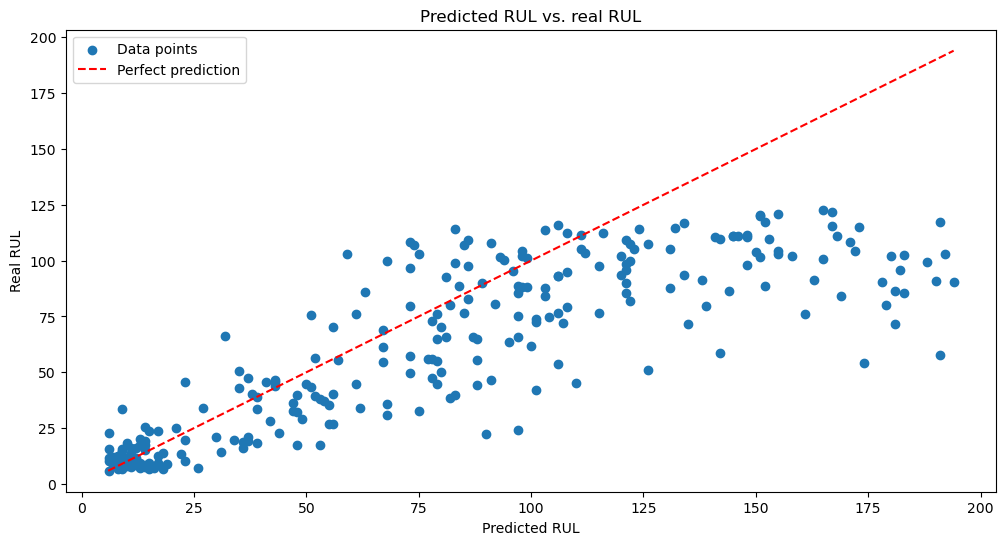

In [36]:
output_2 = result_2[4].to('cpu')
plot_results(output_2, FD002_test_targets)

## FD003 

In [37]:
columns_to_drop = columns_to_remove(FD003_train)
param_grid_baseline_rul_piecewise = {
    "model_cls": LSTMModel,
    "model_params": {
            "lstm_hidden_sizes":   [128, 64, 32],
            "fc_hidden_sizes": [64, 128],
            "output_size": 1,
            "activation": nn.ReLU,
            "dropout": 0.0,
        },
    "scaler_cls": StandardScaler,
    "window_size": 30,
    "stride": 1,
    "batch_size": 128,
    "initial_rul": 125, # Set initial rul for piece-wise RUL
    "optimizer_cls": optim.Adam,
    "lr": 0.001,
    "num_epochs": 10,
    "columns_to_drop": columns_to_drop
}


result_3 = grid_search("FD003", param_grid_baseline_rul_piecewise, "baseline")


2024-06-01 19:52:42,416	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0).
2024-06-01 19:52:42,420	INFO tune.py:1007 -- Wrote the latest version of all result files and experiment state to '/home/jovyan/ray_results/train_model_2024-06-01_19-51-47' in 0.0084s.
2024-06-01 19:52:42,425	INFO tune.py:1039 -- Total run time: 54.74 seconds (54.72 seconds for the tuning loop).


Best trial RMSE validation loss (average over folds): 16.78329368417213
Best trial config: {'model_cls': <class '__main__.LSTMModel'>, 'model_params': {'lstm_hidden_sizes': [128, 64, 32], 'fc_hidden_sizes': [64, 128], 'output_size': 1, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.0, 'input_size': 19}, 'scaler_cls': <class 'sklearn.preprocessing._data.StandardScaler'>, 'window_size': 30, 'stride': 1, 'batch_size': 128, 'initial_rul': 125, 'optimizer_cls': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'num_epochs': 10, 'columns_to_drop': ['operational_setting_3', 'sensor_1', 'sensor_5', 'sensor_16', 'sensor_18', 'sensor_19']}
Epoch 1/10, Train Loss: 3660.6615839729534
Epoch 2/10, Train Loss: 1145.4616759004648
Epoch 3/10, Train Loss: 213.71100875229862
Epoch 4/10, Train Loss: 159.44806363289817
Epoch 5/10, Train Loss: 125.29101647271051
Epoch 6/10, Train Loss: 102.2980963277538
Epoch 7/10, Train Loss: 87.75148994044254
Epoch 8/10, Train Loss: 81.60488175509269
E

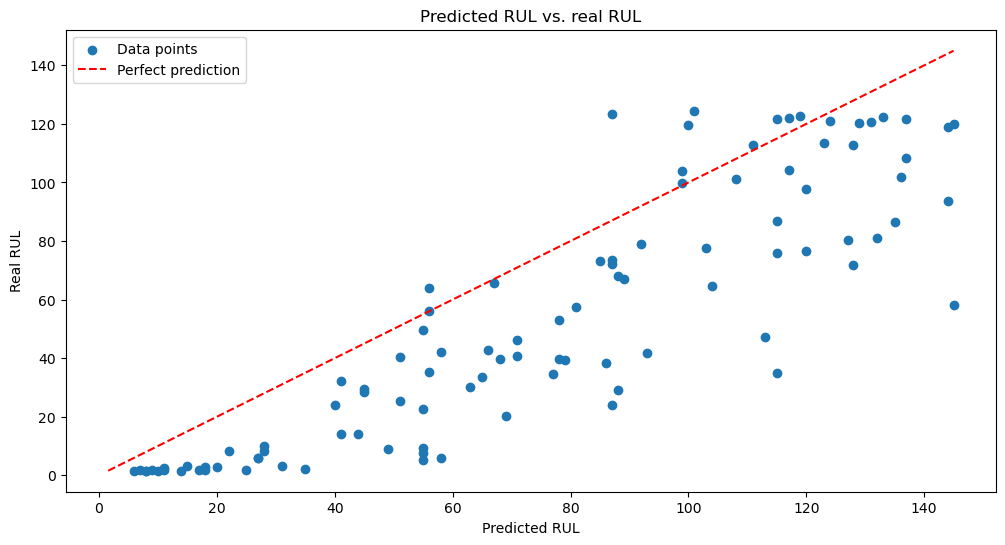

In [38]:
output_3 = result_3[4].to('cpu')
plot_results(output_3, FD003_test_targets)

## FD004

In [39]:
columns_to_drop = columns_to_remove(FD004_train)
param_grid_baseline_rul_piecewise = {
    "model_cls": LSTMModel,
    "model_params": {
            "lstm_hidden_sizes":   [128, 64, 32],
            "fc_hidden_sizes": [64, 128],
            "output_size": 1,
            "activation": nn.ReLU,
            "dropout": 0.0,
        },
    "scaler_cls": StandardScaler,
    "window_size": 18,
    "stride": 1,
    "batch_size": 128,
    "initial_rul": 125, # Set initial rul for piece-wise RUL
    "optimizer_cls": optim.Adam,
    "lr": 0.001,
    "num_epochs": 10,
    "columns_to_drop": columns_to_drop
}


result_4 = grid_search("FD004", param_grid_baseline_rul_piecewise, "baseline")

2024-06-01 19:54:34,110	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0).
2024-06-01 19:54:34,113	INFO tune.py:1007 -- Wrote the latest version of all result files and experiment state to '/home/jovyan/ray_results/train_model_2024-06-01_19-52-52' in 0.0108s.
2024-06-01 19:54:34,116	INFO tune.py:1039 -- Total run time: 102.09 seconds (102.06 seconds for the tuning loop).


Best trial RMSE validation loss (average over folds): 22.509913082733092
Best trial config: {'model_cls': <class '__main__.LSTMModel'>, 'model_params': {'lstm_hidden_sizes': [128, 64, 32], 'fc_hidden_sizes': [64, 128], 'output_size': 1, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.0, 'input_size': 25}, 'scaler_cls': <class 'sklearn.preprocessing._data.StandardScaler'>, 'window_size': 18, 'stride': 1, 'batch_size': 128, 'initial_rul': 125, 'optimizer_cls': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'num_epochs': 10, 'columns_to_drop': []}
Epoch 1/10, Train Loss: 2462.60524130509
Epoch 2/10, Train Loss: 1699.2266747171034
Epoch 3/10, Train Loss: 1427.7712974377278
Epoch 4/10, Train Loss: 534.6689184898753
Epoch 5/10, Train Loss: 485.0833299576969
Epoch 6/10, Train Loss: 467.3291617081304
Epoch 7/10, Train Loss: 444.20079512660277
Epoch 8/10, Train Loss: 419.88880342218374
Epoch 9/10, Train Loss: 409.4073282763562
Epoch 10/10, Train Loss: 394.03281559965535
Te

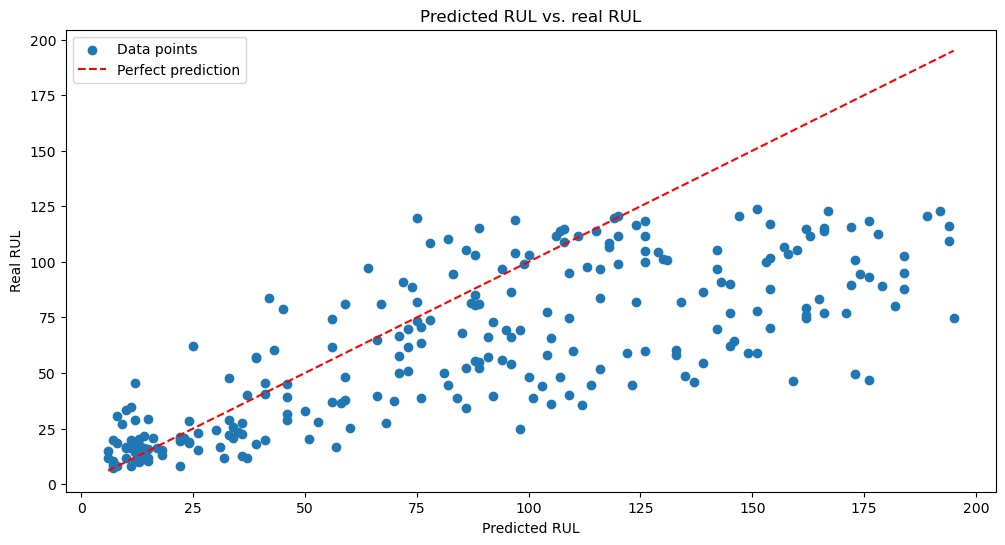

In [40]:
output_4 = result_4[4].to('cpu')
plot_results(output_4, FD004_test_targets)

## Grid search LSTM
We planned to do a proper grid search. However, we were unable to conduct it due to time constraints. Especially when increasing the number of epochs and for the larger datasets, A grid search for one datasets already takes up at least an hour....

In [ ]:
columns_to_drop = columns_to_remove(FD001_train)
param_grid_lstm = {
    "model_cls": LSTMModel,
    "model_params": {
            "lstm_hidden_sizes":  tune.grid_search([[128, 64, 32], [64, 32]] ),
            "fc_hidden_sizes": tune.grid_search([[64, 128], [32, 64, 128]]),
            "output_size": 1,
            "activation": nn.ReLU,
            "dropout": tune.grid_search([0.0, 0.3]),
        },
    "scaler_cls": tune.grid_search([[StandardScaler, MinMaxScaler]]),
    "window_size": tune.grid_search([30, 15]),
    "stride": 1,
    "batch_size": tune.grid_search([128]),
    "initial_rul": tune.grid_search([125]),
    "optimizer_cls": optim.Adam,
    "lr": tune.grid_search([0.001, 0.0001]),
    "num_epochs": tune.grid_search([10, 20]),
    "columns_to_drop": tune.grid_search([columns_to_drop])
}
results = grid_search("FD001", param_grid_lstm, "lstm")

In [ ]:
columns_to_drop = columns_to_remove(FD002_train)
param_grid_lstm = {
    "model_cls": LSTMModel,
    "model_params": {
            "lstm_hidden_sizes":  tune.grid_search([[128, 64, 32], [64, 32]] ),
            "fc_hidden_sizes": tune.grid_search([[64, 128], [32, 64, 128]]),
            "output_size": 1,
            "activation": nn.ReLU,
            "dropout": tune.grid_search([0.0, 0.3]),
        },
    "scaler_cls": tune.grid_search([[StandardScaler, MinMaxScaler]]),
    "window_size": tune.grid_search([20]),
    "stride": 1,
    "batch_size": tune.grid_search([128]),
    "initial_rul": tune.grid_search([125]),
    "optimizer_cls": optim.Adam,
    "lr": tune.grid_search([0.001, 0.0001]),
    "num_epochs": tune.grid_search([10, 30]),
    "columns_to_drop": tune.grid_search([columns_to_drop])
}
results = grid_search("FD002", param_grid_lstm, "lstm")

In [ ]:
columns_to_drop = columns_to_remove(FD003_train)
param_grid_lstm = {
    "model_cls": LSTMModel,
    "model_params": {
            "lstm_hidden_sizes":  tune.grid_search([[128, 64, 32], [64, 32]] ),
            "fc_hidden_sizes": tune.grid_search([[64, 128], [32, 64, 128]]),
            "output_size": 1,
            "activation": nn.ReLU,
            "dropout": tune.grid_search([0.0, 0.3]),
        },
    "scaler_cls": tune.grid_search([[StandardScaler, MinMaxScaler]]),
    "window_size": tune.grid_search([30]),
    "stride": 1,
    "batch_size": tune.grid_search([128]),
    "initial_rul": tune.grid_search([125]),
    "optimizer_cls": optim.Adam,
    "lr": tune.grid_search([0.001, 0.0001]),
    "num_epochs": tune.grid_search([10, 30]),
    "columns_to_drop": tune.grid_search([columns_to_drop])
}
results = grid_search("FD003", param_grid_lstm, "lstm")

In [ ]:
columns_to_drop = columns_to_remove(FD004_train)
param_grid_lstm = {
    "model_cls": LSTMModel,
    "model_params": {
            "lstm_hidden_sizes":  tune.grid_search([[128, 64, 32], [64, 32]] ),
            "fc_hidden_sizes": tune.grid_search([[64, 128], [32, 64, 128]]),
            "output_size": 1,
            "activation": nn.ReLU,
            "dropout": tune.grid_search([0.0, 0.3]),
        },
    "scaler_cls": tune.grid_search([[StandardScaler, MinMaxScaler]]),
    "window_size": tune.grid_search([19]),
    "stride": 1,
    "batch_size": tune.grid_search([128]),
    "initial_rul": tune.grid_search([125]),
    "optimizer_cls": optim.Adam,
    "lr": tune.grid_search([0.001, 0.0001]),
    "num_epochs": tune.grid_search([10, 30]),
    "columns_to_drop": tune.grid_search([columns_to_drop])
}
results = grid_search("FD004", param_grid_lstm, "lstm")

# HDNN Model

The HDNN model already didn't perform very well on FD001 so we didn't test it on the other datasets.

In [48]:
columns_to_drop = ['operational_setting_1', 'operational_setting_2', 'operational_setting_3', 
               'sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 
               'sensor_16', 'sensor_18', 'sensor_19']
param_grid_hdnn = {
    "model_cls": HybridDeepNeuralNetwork,
    "model_params": {
            "window_size": 30,
        },
    "scaler_cls": MinMaxScaler,
    "window_size": 30,
    "stride": 1,
    "batch_size": 512,
    "initial_rul": 130,
    "optimizer_cls": optim.Adam,
    "lr": 0.001,
    "num_epochs": 100,
    "columns_to_drop": columns_to_drop
}


results = grid_search("FD001", param_grid_hdnn, "hdnn")

2024-06-01 20:21:53,786	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0).
2024-06-01 20:21:53,790	INFO tune.py:1007 -- Wrote the latest version of all result files and experiment state to '/home/jovyan/ray_results/train_model_2024-06-01_20-16-11' in 0.0143s.
2024-06-01 20:21:53,795	INFO tune.py:1039 -- Total run time: 341.99 seconds (341.95 seconds for the tuning loop).


Best trial RMSE validation loss (average over folds): 41.2579695178591
Best trial config: {'model_cls': <class '__main__.HybridDeepNeuralNetwork'>, 'model_params': {'window_size': 30, 'input_size': 15}, 'scaler_cls': <class 'sklearn.preprocessing._data.MinMaxScaler'>, 'window_size': 30, 'stride': 1, 'batch_size': 512, 'initial_rul': 130, 'optimizer_cls': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'num_epochs': 100, 'columns_to_drop': ['operational_setting_1', 'operational_setting_2', 'operational_setting_3', 'sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']}
Epoch 10/100, Train Loss: 3987.1256696428572
Epoch 20/100, Train Loss: 2404.3552664620534
Epoch 30/100, Train Loss: 1963.3481828962053
Epoch 40/100, Train Loss: 1888.4148716517857
Epoch 50/100, Train Loss: 1879.540363420759
Epoch 60/100, Train Loss: 1879.34462890625
Epoch 70/100, Train Loss: 1876.9640799386161
Epoch 80/100, Train Loss: 1878.9490931919643
Epoch 90/100, Train Loss: 1880.809193

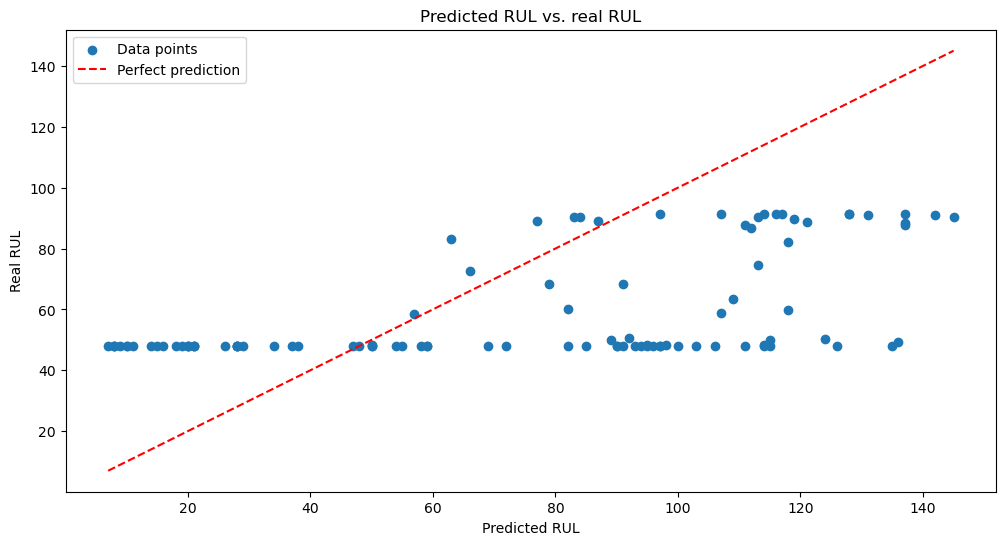

In [49]:
output = results[4].to('cpu')
plot_results(output, FD001_test_targets)

# Conclusion 
- Unfortunately, both models are underperforming and only achieve a RMSE above 30.
- The LSTM models perform better on FD001 and FD003 but from our data exploration this was expected since FD002 and FD004 are much more complex and don't exhibit clear trends.
- The LSTM seems to be overfitting, since the validation loss is much smaller than the final RMSE of the test set.
- Also the HDNN performed worse than the LSTM and is underfitting despite following the architecture of the paper. This could be due to some local minima since the train loss seems to stagnate after 40 training epochs and doesn't improve. Another reason  could be due to some implementation errors and lack of clarity of the paper. E.g., the authors don't include the learning rate or the type of padding used for the CNN. Properly reproducing a paper would require a more careful analysis and understanding of the paper which wasn't possible due to time constraints.
- As future steps, more careful hyperparameter tuning and construction of the model could increase the performance. However, there are many factors that contribute to the suboptimal performance. Since training  with 5-fold-cross validation takes a lot of times, it's difficult to test out all the factors and to find the cause.
- Also, other feature selection strategies could help to improve the performance. We simply removed constant features, but e.g. Removing features that also have a low correlation to the target RUL.